In [35]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
import random
import math
import matplotlib as mpl
sns.set(style='white',  font_scale=1.2)
tqdm.pandas(ascii=True)
%matplotlib inline

#https://networkx.github.io/documentation/networkx-1.7/tutorial/tutorial.html
# color: https://seaborn.pydata.org/tutorial/color_palettes.html

#sns.palplot(sns.color_palette("gist_rainbow", 10))

#nx.draw(G, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
#zip -r tutu.zip onegene onegene_astree/ onepatient/

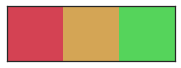

In [36]:
tcolor = {'Cancer':'#d44253', 'Border':  '#d4a555', 'Normal':"#55d45b" }
sns.palplot(list(tcolor.values()))

In [37]:

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


def edge2color(edges):
    colors = []
    for i in edges:
        if 'Cancer' in i[0]:
            colors.append(tcolor['Cancer'])
            
        if 'Border' in i[0]:
            colors.append(tcolor['Border'])
            
        if 'Normal' in i[0]:
            colors.append(tcolor['Normal'])
    return colors


def plot_for_one_gene_as_tree(df, name = "Her2", vmax = 5, vmin = -0.5):
    
    Root = name #'ClinicalData'
    Tissue = ['Cancer', 'Border', 'Normal']
    Patients = ['Patient%s' % str(i).zfill(2) for i in range(1,17)]

    Her2 = ['Her2', 'Her2-SHC', 'Her2-GRB2', 'Her2-GRB2-SHC']
    ER =  ['ER','ER-GATA3','ER-FOXA1','ER-GATA3-FOXA1']
    PR =  ['PR', 'PR-TIF2', 'PR-SRC1', 'PR-TIF2-SRC1']
    SCRIB =  ['SCRIB','SCRIB-VANGL1','SCRIB-NOS1AP','SCRIB-VANGL1-NOS1AP']
    WASF3 =  [ 'WASF3','WASF3-CYFIP1','WASF3-NCKAP1','WASF3-CYFIP1-NCKAP1']

    SinglePro = {} #single pro
    DoublePro1 = {} #two-complex
    DoublePro2 = {} #two-complex
    TriplePro = {} #three-complex

    allg = {'Her2': Her2,  'ER':ER, 'PR': PR, 'SCRIB':SCRIB, 'WASF3':WASF3}

    for i in [allg[name]]: #Her2, ER, PR, SCRIB, WASF3
        s = i[0:1]
        d1 = i[1:2]
        d2 = i[2:3]
        t = i[-1:]
        n = i[0]
        SinglePro[n] = s
        DoublePro1[n] = d1
        DoublePro2[n] = d2    
        TriplePro[n] = t



    nodes0 = {}
    nodes1 = {} #gene nodes, labels
    nodes2 = {} #Tissue nodes, lables
    nodes3 = {} #Single protein nodes, labels
    nodes41 = {} #first Double protein nodes, labels
    nodes42 = {} #second Double protein nodes2, labels
    nodes5 = {} #Triple protein nodes, labels

    edges1 = [] #gene edges
    edges2 = [] #Tissue edges
    edges3 = [] #Single Protien_edges
    edges41 = [] #first Double Protien_edges
    edges42 = [] #second Double Protien_edges
    edges5 = [] #Triple Protien_edges


    nodes0[Root] = Root


    n1 = Root
    i = Root
    for j in Tissue:
        n2 = '%s_%s_%s' % (Root, i, j)
        nodes2[n2] = j 
        edges2.append((n1, n2))

        for k in Patients:
            n3 = '%s_%s_%s_%s' % (Root, i, j, k)
            nodes3[n3] = i #name as single pro
            edges3.append((n2, n3))

            for l in DoublePro1[i]:
                n41 = '%s_%s_%s_%s_%s' % (Root, i, j, k, l)
                nodes41[n41] = l #name as double pro
                edges41.append((n3, n41))

                for m in DoublePro2[i]:
                    n42 = '%s_%s_%s_%s_%s_%s' % (Root, i, j, k, l, m)
                    nodes42[n42] = m #name as double pro
                    edges42.append((n41, n42))

                    for t in TriplePro[i]:
                        n5 = '%s_%s_%s_%s_%s' % (Root, i, j,  k,  t)
                        nodes5[n5] = t
                        edges5.append((n42, n5))  

    nodes3_value = df[list(nodes3.values())[0]].tolist()
    nodes41_value = df[list(nodes41.values())[0]].tolist()
    nodes42_value = df[list(nodes42.values())[0]].tolist()
    nodes5_value = df[list(nodes5.values())[0]].tolist()


    ## Graph object
    G = nx.Graph()
    # add nodes & edges
    for nodes in [nodes0, nodes1, nodes2, nodes3, nodes41, nodes42,  nodes5]:
        G.add_nodes_from(nodes.keys())
    for edges in [edges1, edges2, edges3, edges41, edges42, edges5]:
        G.add_edges_from(edges)
    nx.is_tree(G)
    
    ## Layout
    #layout = nx.spring_layout(G,iterations=500)
    #layout = nx.layout.circular_layout(G)
    #layout = nx.layout.kamada_kawai_layout(G, scale  = 0.5)
    pos = hierarchy_pos(G, root=list(G.nodes)[0], width = 1, vert_gap = 0.008, vert_loc = 1, xcenter = 1) # width = 2*math.pi, xcenter=0, vert_gap = 0.5
    layout = {}
    for u, (x, y) in pos.items():
        if u == name:
            loc = {u:(x, y+0.018)}
        elif u == '%s_%s_Cancer' % (name, name):
            loc = {u:(x, y+0.005)}
        elif u == '%s_%s_Border' % (name, name):
            loc = {u:(x, y+0.005)}
        elif u == '%s_%s_Normal' % (name, name):
            loc = {u:(x, y+0.005)}
        else:
            loc = {u:(x,y)}

        layout.update(loc)

#     pos = hierarchy_pos(G, root=list(G.nodes)[0], width = 2*math.pi, xcenter=0, vert_gap = 0.5) # 
#     layout = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
 

    ## Plot
    plt.figure(figsize=(20, 8))
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["#03fc77", "white","#fc03ca"], N = 1000, gamma = 1.)

    # ############################nodes0###################################################
    nx.draw_networkx_nodes(G, layout, nodelist= nodes0.keys(), 
                           node_size= [2500], # a LIST of sizes
                           node_color='#03d7fc') 
    nx.draw_networkx_labels(G, layout, labels = nodes0)


    #############################nodes2###################################################
    for kv, e in zip(nodes2.items(), edges2):

        k, v = kv
        if v == 'Cancer':
            nodes2_shape = 'p' #‘so^>v<dph8’ 
            color = tcolor['Cancer']
            
        if v == 'Border':
            nodes2_shape = '8'       
            color =  tcolor['Border']
            
        if v == 'Normal':
            nodes2_shape = 'o' 
            color =  tcolor['Normal']
            
        nx.draw_networkx_nodes(G, layout, nodelist= [k], node_size= [2500], node_shape = nodes2_shape, node_color = color) #node_color = nodes2_color,  
        nx.draw_networkx_edges(G, layout,edgelist = [e], width=1,  edge_color= 'grey',style='--') #edge_color=color, 
        
    nx.draw_networkx_labels(G, layout, labels = nodes2)
    #############################nodes3###################################################
    nc3 = nx.draw_networkx_nodes(G, layout, nodelist= nodes3.keys(), node_shape = 'o', label ='single protein: %s' % list(nodes3.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes3_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges3, width=0.8, edge_color=edge2color(edges3),  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc3.set_edgecolor('grey')

    #############################nodes4###################################################
    nc4 = nx.draw_networkx_nodes(G, layout, nodelist= nodes41.keys(), node_shape = '^', label ='double complex: %s' % list(nodes41.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes41_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    
    nx.draw_networkx_edges(G, layout,edgelist = edges41, width=0.8, edge_color=edge2color(edges41),  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc4.set_edgecolor('grey')


    ############################# nodes4-sencend ###################################################
    nc44 = nx.draw_networkx_nodes(G, layout, nodelist= nodes42.keys(), node_shape = '>', label ='double complex: %s' % list(nodes42.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes42_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges42, width=0.8, edge_color=edge2color(edges42),  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc44.set_edgecolor('grey')


    #############################nodes5###################################################
    nc5 = nx.draw_networkx_nodes(G, layout, nodelist= nodes5.keys(), node_shape = 's', 
                           node_size= [200], # a LIST of sizes
                           node_color= nodes5_value, cmap=cmap, label ='triple complex: %s' % list(nodes5.values())[0],
                                 vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges5, width=0.8, edge_color=edge2color(edges5),  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)\
    nc5.set_edgecolor('grey')

    cb1 = plt.colorbar(nc4, shrink=0.5, pad = 0.001)
    cb1.set_label('Expression ')

    plt.legend(ncol = 2, facecolor ='white', edgecolor = 'white', markerfirst = True, markerscale = 1, labelspacing = 0.5)
    ax = plt.gca()
    leg = ax.get_legend()
    for lh in leg.legendHandles:
        #lh.set_edgecolor('#cccccc')
        lh.set_facecolor(matplotlib.colors.to_hex(cmap(0.4)))


    #plt.title("Clinical Screening for %s" % name)

    plt.axis('off')

    #plt.colorbar(nc4, shrink=0.25,pad = 0.01)
    
    plt.savefig('./results/%s.pdf' % name, bbox_inches='tight')
    
    return G

In [38]:
name = 'Her2'

In [39]:
df = pd.read_excel('./clincal_data.xlsx').fillna(0)
df['Patient_ID'] =  ['Patient%s' % str(i).zfill(2) for i in df.Patient_ID]

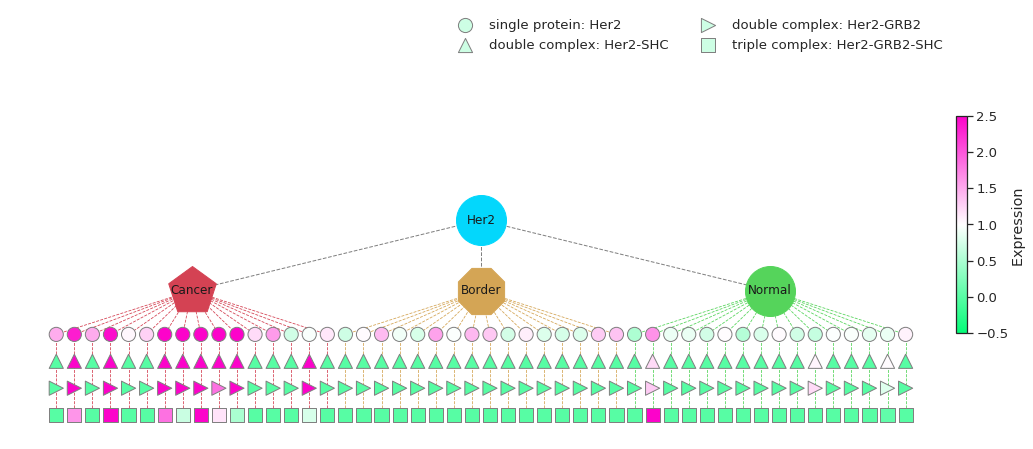

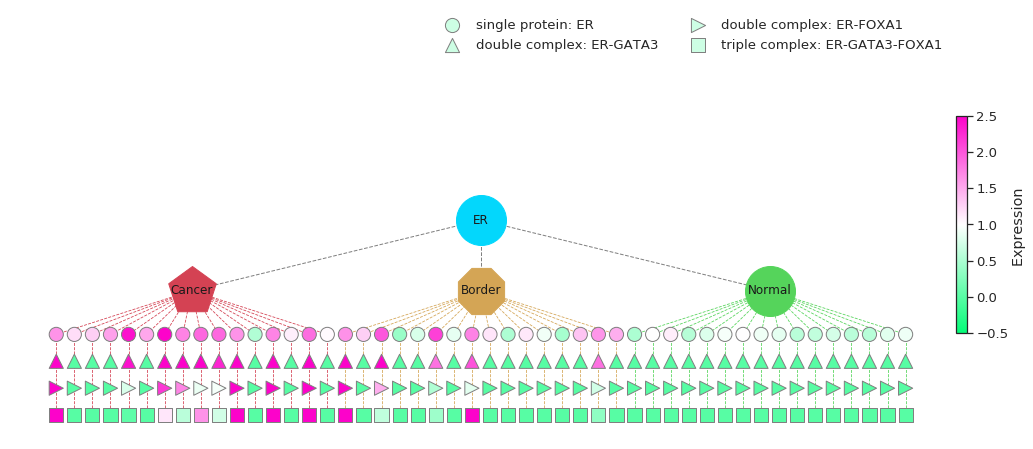

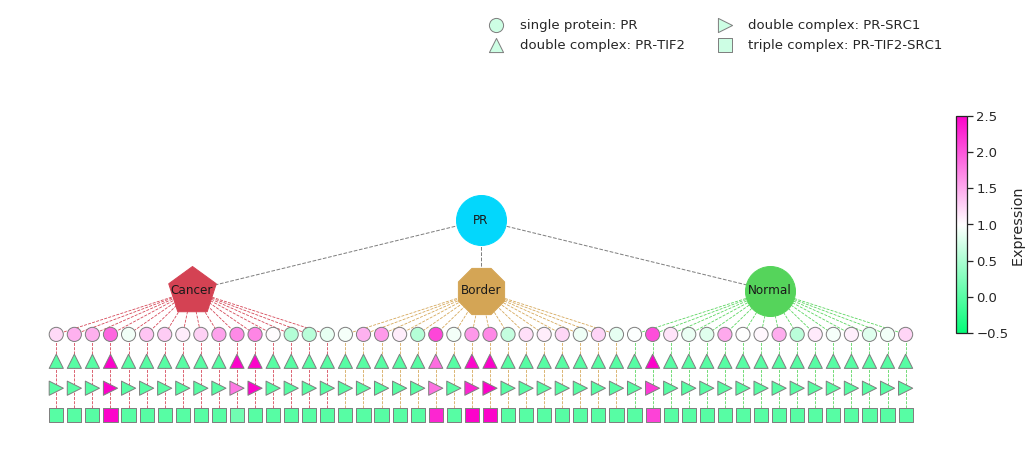

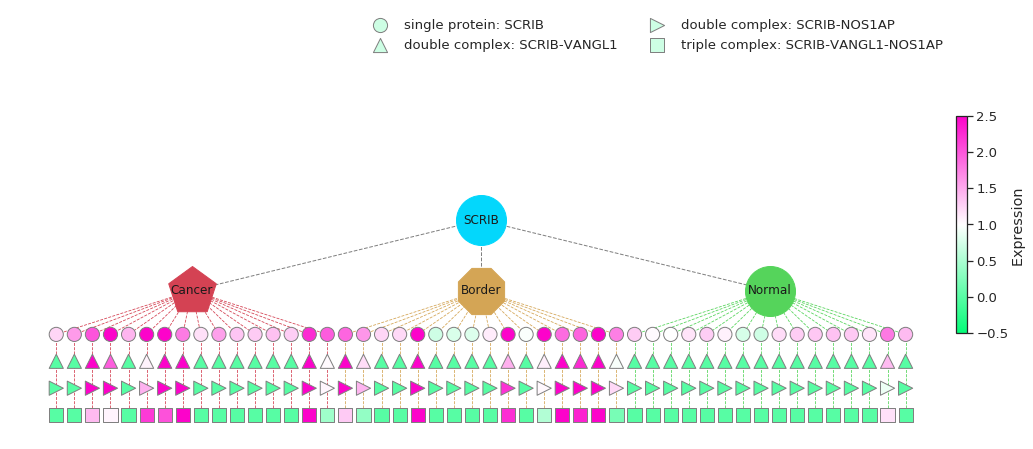

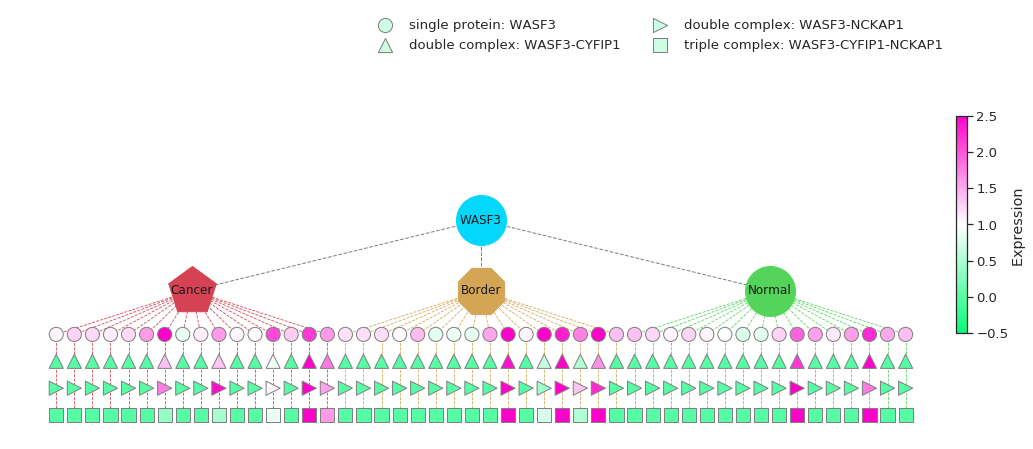

In [40]:
plot_for_one_gene_as_tree(df, name = "Her2",  vmax= 2.5)
plot_for_one_gene_as_tree(df, name = "ER",  vmax= 2.5)
plot_for_one_gene_as_tree(df, name = "PR",  vmax= 2.5)
plot_for_one_gene_as_tree(df, name = "SCRIB",  vmax= 2.5)
plot_for_one_gene_as_tree(df, name = "WASF3",  vmax= 2.5)